<a href="https://colab.research.google.com/github/anubhavgupta1/Dive-Into-Deep-Learning/blob/main/Deep%20Convolutional%20Neural%20Networks/GoogleNet/mxnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  GoogleNet

In [ ]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

In [2]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

### Reading Data

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

### Model

In [4]:
class Inception(nn.Block):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4,verbose = False, **kwargs):
        super(Inception, self).__init__(**kwargs)
        
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1,activation='relu')
        
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2,activation='relu')
        
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')

    def forward(self, x):
        p1   = self.p1_1(x)
        p2_1 = self.p2_1(x)
        p2_2 = self.p2_2(p2_1)
        p3_1 = self.p3_1(x)
        p3_2 = self.p3_2(p3_1)
        p4_1 = self.p4_1(x)
        p4_2 = self.p4_2(p4_1)
        
        # Concatenate the outputs on the channel dimension
        return np.concatenate((p1, p2_2, p3_2, p4_2), axis=1)

In [5]:
Inception(64, (96, 128), (16, 32), 32)

Inception(
  (p1_1): Conv2D(-1 -> 64, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
  (p2_1): Conv2D(-1 -> 96, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
  (p2_2): Conv2D(-1 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (p3_1): Conv2D(-1 -> 16, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
  (p3_2): Conv2D(-1 -> 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
  (p4_1): MaxPool2D(size=(3, 3), stride=(1, 1), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (p4_2): Conv2D(-1 -> 32, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
)

In [6]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [7]:
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
       nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [8]:
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [9]:
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [10]:
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())

In [11]:
net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

In [12]:
net.initialize()

In [13]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.summary(X)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 96, 96)               0
        Activation-1                    <_Symbol conv6_relu_fwd>               0
        Activation-2                             (1, 64, 48, 48)               0
            Conv2D-3                             (1, 64, 48, 48)            3200
         MaxPool2D-4                             (1, 64, 24, 24)               0
        Activation-5                    <_Symbol conv7_relu_fwd>               0
        Activation-6                             (1, 64, 24, 24)               0
            Conv2D-7                             (1, 64, 24, 24)            4160
        Activation-8                    <_Symbol conv8_relu_fwd>               0
        Activation-9                            (1, 192, 24, 24)               0
           Conv2D-10        

In [14]:
X = np.random.uniform(size=(1, 1, 96, 96))
for layer in net:
    print(layer.summary(X))
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 96, 96)               0
        Activation-1                             (1, 64, 48, 48)               0
            Conv2D-2                             (1, 64, 48, 48)            3200
         MaxPool2D-3                             (1, 64, 24, 24)               0
Parameters in forward computation graph, duplicate included
   Total params: 3200
   Trainable params: 3200
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 3200
--------------------------------------------------------------------------------
None
sequential0 output shape:	 (1, 64, 24, 24)
--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
         

### Training

loss 0.262, train acc 0.901, test acc 0.909
301.1 examples/sec on gpu(0)


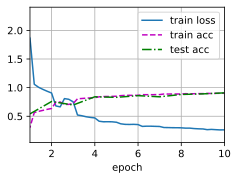

In [15]:
lr, num_epochs = 0.1, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)